In [2]:
import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, History
from sklearn.metrics import classification_report

import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from os.path import exists

Using TensorFlow backend.


In [9]:
train_path = '.\\Documents\\Datasets\\base_dir_OverSample\\train_dir\\'
valid_path = '.\\Documents\\Datasets\\base_dir_OverSample\\val_dir\\'
test_path = '.\\Documents\\Datasets\\base_dir_OverSample\\test_dir\\'

num_train_samples = 37664
num_val_samples = 1004
train_batch_size = 32
val_batch_size = 32
image_size = 128

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [10]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.vgg16.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 37664 images belonging to 7 classes.
Found 1004 images belonging to 7 classes.
Found 2002 images belonging to 7 classes.


In [11]:
basemodel = VGG16(input_shape=(image_size, image_size, 3), include_top = False)
basemodel.summary()
    
for layer in basemodel.layers:
    layer.trainable = False
     
inputs = basemodel.input   
x = basemodel.output
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(7, activation='softmax')(x)
model2 = Model(inputs, outputs)
model2.summary()
    

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [12]:
train_labels = train_batches.classes
valid_labels = valid_batches.classes
test_labels = test_batches.classes

In [13]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 0.9073476270778126,
 1: 0.9550180029413257,
 2: 0.9270453874175445,
 3: 0.9456188802410244,
 4: 0.9000621325813698,
 5: 1.2518779498770192,
 6: 1.2426261959749259}

In [14]:
# Train model
model2.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_loss', patience = 10)]
history2 = model2.fit(train_batches, steps_per_epoch=train_steps, class_weight=class_weights,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1177.0 steps, validate for 32.0 steps
Epoch 1/50
1177/1177 [==============================] - 1580s 1s/step - loss: 1.3475 - accuracy: 0.5040 - mse: 0.0896 - val_loss: 0.5509 - val_accuracy: 0.8386 - val_mse: 0.0349
Epoch 2/50
1177/1177 [==============================] - 1564s 1s/step - loss: 0.9103 - accuracy: 0.6358 - mse: 0.0680 - val_loss: 0.5545 - val_accuracy: 0.8416 - val_mse: 0.0337
Epoch 3/50
1177/1177 [==============================] - 1567s 1s/step - loss: 0.7817 - accuracy: 0.6855 - mse: 0.0597 - val_loss: 0.5536 - val_accuracy: 0.8416 - val_mse: 0.0332
Epoch 4/50
1177/1177 [==============================] - 1554s 1s/step - loss: 0.7034 - accuracy: 0.7163 - mse: 0.0544 - val_loss: 0.5176 - val_accuracy: 0.8546 - val_mse: 0.0305
Epoch 5/50
1177/1177 [==============================] - 1548s 1s/step - loss: 0.6477 - accuracy: 0.7389 - mse: 0.0506 - val_loss: 0.5144 - val_accuracy: 0.8496 - val_mse: 0.0313
Epoch 6/50
1

In [15]:
if not exists('BestModel'):
        os.mkdir('BestModel')
model2.save('.//BestModel//' + 'VGG16_50epochs.h5')

In [16]:
model2 = load_model('.//BestModel//' + 'VGG16_50epochs.h5')

In [17]:
test_loss, test_accuracy, test_mse = model2.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

  ...
    to  
  ['...']
2002/2002 [==============================] - 104s 52ms/step - loss: 0.5519 - accuracy: 0.8487 - mse: 0.0320

Test Set Accuracy:  84.86513495445251 % 
Test Set Loss: 0.5519019832727934 
Test Set MSE: 0.03196358


In [18]:
test_labels = test_batches.classes
print(test_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [19]:
predictions2 = model2.predict(test_batches, verbose=1)
print(predictions2.shape)
pre_labels = np.argmax(predictions2, axis = 1) 
print(classification_report(test_labels, pre_labels))

2002/2002 [==============================] - 100s 50ms/step
(2002, 7)
              precision    recall  f1-score   support

           0       0.51      0.44      0.47        55
           1       0.49      0.53      0.51        64
           2       0.55      0.42      0.48       160
           3       0.38      0.43      0.40        14
           4       0.34      0.41      0.37        83
           5       0.93      0.95      0.94      1603
           6       0.88      0.65      0.75        23

    accuracy                           0.85      2002
   macro avg       0.58      0.55      0.56      2002
weighted avg       0.85      0.85      0.85      2002



In [37]:
def plot_confusion_matrix(cm, classes,
                          name="VGG16",
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,8))
    plt.rcParams['font.size'] = 20
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    
    fig.savefig('.//BestModel//' + name + '_confusion_matrix.png', dpi=300)

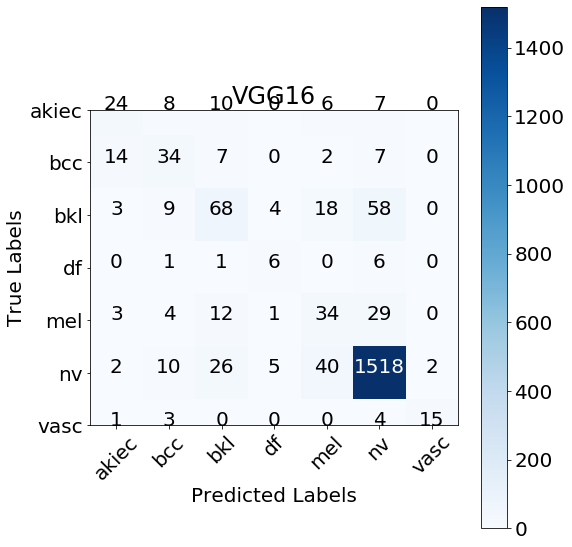

In [38]:
cm = confusion_matrix(test_labels,  predictions2.argmax(axis=1))
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [40]:
def plot_model_history(model_history, name):
    
    fig = plt.figure(figsize=(10,10))

    #Summarize history for accuracy
    ax1 = plt.subplot(1,2,1) 
    ax1.plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    ax1.plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    ax1.legend(['train', 'validation'], loc='best')
    
    #Summarize history for loss
    ax2 = plt.subplot(1,2,2) 
    ax2.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    ax2.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    ax2.legend(['train', 'validation'], loc='best')
    
    #Plot and save figures
    plt.show()
    fig.savefig('.//BestModel//' + name + '_model_history.png', dpi=300)

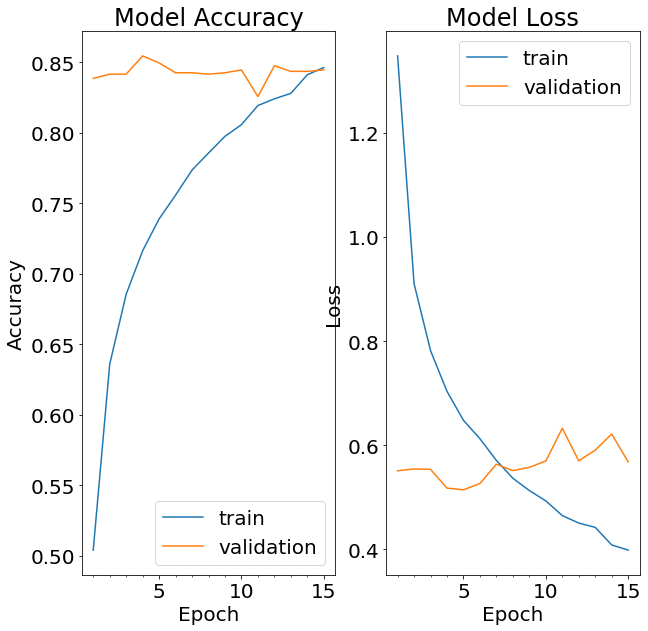

In [41]:
plot_model_history(history2, "VGG16")

Test image shape:  (1, 128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predictions:  [[8.3108880e-03 8.9920509e-01 3.0093310e-02 3.3045205e-04 5.1586595e-03
  5.6175720e-02 7.2567596e-04]]
 lesions type: 1


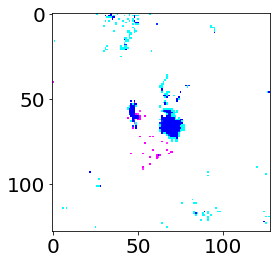

In [39]:
test_img = test_batches[2][0]
print("Test image shape: ",test_img.shape)
predictions= model2.predict(test_img)
print("predictions: ",predictions)
def max_ypred(y_pred):
    max_ypred2 = np.max(predictions)
    for i,n in enumerate(predictions[0]):
        if n == max_ypred2:
            return i

print(' lesions type: {}'.format(max_ypred(predictions)))
plt.imshow(test_img.reshape(128, 128, 3))